In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score
)
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

In [271]:
# ===============================================================
# COACH CHANGE PREDICTION — DATA PREPARATION
# ===============================================================

# Load Data
coaches = pd.read_csv("data/coaches.csv")
teams = pd.read_csv("data/teams.csv")
awards_players = pd.read_csv("data/awards_players.csv")

# Load season 11
coaches_new = pd.read_csv("season11/coaches.csv") 
teams_new = pd.read_csv("season11/teams.csv")

coaches = pd.concat([coaches, coaches_new], ignore_index=True)
teams = pd.concat([teams, teams_new], ignore_index=True)

# TARGET: "DID A CHANGE HAPPEN THIS SEASON?"
# If max_stint > 0, it means the starter (Stint 0) was replaced.
stint_counts = coaches.groupby(["tmID", "year"])["stint"].max().reset_index()
stint_counts = stint_counts.rename(columns={"stint": "max_stint_in_season"})

# Merge this info back to the coaches
coaches = coaches.merge(stint_counts, on=["tmID", "year"], how="left")

# Target = 1 if there was more than 1 coach (max_stint > 0)
coaches["mid_season_change"] = (coaches["max_stint_in_season"] > 0).astype(int)



# Compute win ratio
coaches["win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)


# Compute Cumulative Win Ratio (Last 3 Years Weighted)
def compute_3yr_weighted_win_ratio(group):
    # Define a custom weighted mean function
    def weighted_avg(x):
        weights = np.arange(1, len(x) + 1)
        return np.sum(x * weights) / np.sum(weights)

    # Apply rolling window of size 3
    # min_periods=1 ensures we still get a value for the 1st and 2nd years
    group["cumulative_win_ratio"] = (
        group["win_ratio"]
        .rolling(window=3, min_periods=1)
        .apply(weighted_avg, raw=True)
    )
    
    group["cumulative_win_ratio"] = group["cumulative_win_ratio"].shift(1)
    return group

coaches = coaches.sort_values(["coachID", "year", "stint"])
coaches = coaches.groupby("coachID", group_keys=False).apply(compute_3yr_weighted_win_ratio)

# Fill NaNs for rookie coaches 
avg_cumulative_win_ratio = coaches["cumulative_win_ratio"].mean(skipna=True)
coaches["cumulative_win_ratio"] = coaches["cumulative_win_ratio"].fillna(avg_cumulative_win_ratio)

# Sort by team and year first
coaches = coaches.sort_values(["tmID", "year", "stint"]).reset_index(drop=True)
# Compute team win ratio
coaches["team_win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)

coaches["prev_team_win_ratio"] = coaches.groupby("tmID")["team_win_ratio"].shift(1)

def compute_team_3yr_weighted(group):
    # Weighted Average Function
    # Weights: [1, 2, 3] -> Most recent season counts 3x more than 3 years ago
    def weighted_avg(x):
        weights = np.arange(1, len(x) + 1)
        return np.sum(x * weights) / np.sum(weights)

    # Apply Shift (To avoid leaks) -> Then Rolling -> Then Weighted Avg
    group["3yr_win_ratio"] = (
        group["team_win_ratio"]
        .shift(1)  # Move stats to "Past" so Year 10 sees Year 7,8,9
        .rolling(window=3, min_periods=1)
        .apply(weighted_avg, raw=True)
    )
    return group

coaches = coaches.sort_values(["tmID", "year", "stint"])
coaches = coaches.groupby("tmID", group_keys=False).apply(compute_team_3yr_weighted)


average_3yr_team_win_ratio = coaches["3yr_win_ratio"].mean(skipna=True)
coaches["3yr_win_ratio"] = coaches["3yr_win_ratio"].fillna(average_3yr_team_win_ratio)


# Expectation gap (current vs. recent average)
coaches["expectation_gap"] = coaches["cumulative_win_ratio"] - coaches["3yr_win_ratio"]



# Filter only Coach of the Year awards
coach_awards = awards_players[awards_players["award"] == "Coach of the Year"].copy()
coach_awards = coach_awards.rename(columns={"playerID": "coachID", "year": "award_year"})

# Merge award info into coaches (many-to-many, one row per award)
coaches_awards = coaches.merge(
    coach_awards[["coachID", "award_year"]],
    on="coachID",
    how="left"
)

# Only keep awards up to and including that season
coaches_awards["award_up_to_season"] = (
    coaches_awards["award_year"] < coaches_awards["year"]
).astype(int)

# Group by coach and season, sum awards
coach_award_count = (
    coaches_awards.groupby(["coachID", "year"])["award_up_to_season"]
    .sum()
    .reset_index()
    .rename(columns={"award_up_to_season": "coach_award_count"})
)

# Merge back into the original coaches dataframe
coaches = coaches.merge(coach_award_count, on=["coachID", "year"], how="left")

# Fill NaNs for coaches with no awards
coaches["coach_award_count"] = coaches["coach_award_count"].fillna(0).astype(int)


# merge teams info into coaches so each coach row has that season's team info
coaches = coaches.merge(
    teams[["year", "tmID", "playoff", "o_pts", "d_pts", "rank"]],
    on=["year", "tmID"],
    how="left",
    validate="m:1"   
)

coaches = coaches.sort_values(["tmID", "year", "stint"]).reset_index(drop=True)

coaches["team_prev_playoff"] = coaches.groupby("tmID")["playoff"].shift(1).map({"Y": 1, "N": 0})


teams_history = teams[["year", "tmID", "o_pts", "d_pts", "playoff"]].copy()
teams_history["year"] = teams_history["year"] + 1  # SHIFT FORWARD: Year 9 stats become Year 10 features

# Merge this "History" into the main dataframe
coaches = coaches.merge(
    teams_history, 
    on=["year", "tmID"], 
    how="left",
    suffixes=("", "_prev") # This avoids collision if columns exist
)

# NEW FEATURE: PYTHAGOREAN EXPECTATION (Underperformance)
# Did the coach lose more games than their points scored stats suggest?
# Formula: Pts^14 / (Pts^14 + OppPts^14)

coaches["prev_pythag_win_pct"] = (
    (coaches["o_pts_prev"].astype(float)**14) / 
    ((coaches["o_pts_prev"].astype(float)**14) + (coaches["d_pts_prev"].astype(float)**14))
)

coaches["prev_underperformance"] = coaches["prev_pythag_win_pct"] - coaches["prev_team_win_ratio"]

coaches["prev_underperformance"] = coaches["prev_underperformance"].fillna(0)
    

# 8. Playoff Streak
coaches["prev_playoff_numeric"] = coaches["playoff_prev"].map({"Y": 1, "N": 0}).fillna(0)

# ... rest of streak logic ...
# Playoff miss streak
def playoff_streak(series):
    streaks = []
    streak = 0
    for made in series:
        if made == 0:
            streak += 1
        else:
            streak = 0
        streaks.append(streak)
    return streaks

coaches["playoff_miss_streak"] = coaches.groupby("tmID")["team_prev_playoff"].transform(playoff_streak)



# NEW FEATURE: TENURE (Years with current team)
coaches = coaches.sort_values(["tmID", "year", "stint"])

# Calculate how many seasons this coach has been with this team (entering this season)
coaches["tenure"] = coaches.groupby(["tmID", "coachID"]).cumcount() + 1


coaches["win_ratio_lag1"] = coaches.groupby("tmID")["team_win_ratio"].shift(1)
coaches["win_ratio_lag2"] = coaches.groupby("tmID")["team_win_ratio"].shift(2)

# Momentum: Recent Trend vs Previous Trend
# If Lag1 (Last Year) is much lower than Lag2 (Year Before), Momentum is Negative.
coaches["momentum"] = coaches["win_ratio_lag1"] - coaches["win_ratio_lag2"]
coaches["momentum"] = coaches["momentum"].fillna(0)


features_to_keep = [
    "tmID", "year", "coachID", "stint", "mid_season_change",
    "cumulative_win_ratio", "3yr_win_ratio", "expectation_gap",
    "coach_award_count", "prev_underperformance", "playoff_miss_streak",
    "tenure", "momentum"
]
# Keep only what we need
final_df = coaches[features_to_keep].copy()

# Inspect Year 
final_df[final_df["year"] == 11].head(20)

/tmp/ipykernel_26364/718205787.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coaches = coaches.groupby("coachID", group_keys=False).apply(compute_3yr_weighted_win_ratio)
/tmp/ipykernel_26364/718205787.py:93: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coaches = coaches.groupby("tmID", group_keys=False).apply(compute_team_3yr_weighted)


,tmID,year,coachID,stint,mid_season_change,cumulative_win_ratio,3yr_win_ratio,expectation_gap,coach_award_count,prev_underperformance,playoff_miss_streak,tenure,momentum
2,ATL,11,meadoma99w,0,0,0.372549,0.485996,-0.113447,1,0.078528,0,3,0.382353
15,CHI,11,chatmda99w,0,0,0.516848,0.421569,0.095279,0,-0.124927,4,1,0.117647
27,CON,11,thibami99w,0,0,0.519078,0.519078,0.000000,2,0.025453,1,8,-0.124006
59,IND,11,dunnli99wc,0,0,0.563677,0.580344,-0.016667,0,0.003728,0,3,0.149877
73,LAS,11,gilloje01w,0,0,0.411765,0.503186,-0.091422,0,0.023545,0,1,-0.050000
89,MIN,11,reevech99w,0,0,0.516848,0.411765,0.105083,0,-0.030380,6,1,-0.058824
102,NYL,11,whisejo99w,0,0,0.550572,0.415196,0.135376,1,0.056378,2,1,0.058824
117,PHO,11,gaineco01w,0,0,0.601307,0.606475,-0.005168,0,-0.028878,0,3,0.196078
143,SAS,11,hugheda99w,0,0,0.527288,0.527288,0.000000,2,0.006836,0,6,-0.218730
154,SEA,11,aglerbr99w,0,0,0.543623,0.569695,-0.026072,0,0.026138,0,3,-0.054054


/home/pjoca/Secretária/Universidade/4ºano/1ºsemestre/AC/ac-data-mining-project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Model Random Forest
Year Target: 10
Treino: (129, 13) | Teste (10): (13, 13)

Evaluation for year 10:
AUC:       0.667
Accuracy:  0.769
Precision: 0.000
Recall:    0.000
F1-score:  0.000
AUC:       0.667
Spearman:  0.244

Teams predicted to change coaches:
Empty DataFrame
Columns: [tmID, coachID, pred_proba, prev_underperformance]
Index: []

Top predicted coach changes (with actual result):
     pred_proba  predicted_change  mid_season_change
132    0.358736                 0                  1
116    0.232970                 0                  0
58     0.176716                 0                  0
1      0.141890                 0                  0
153    0.125740                 0                  0
14     0.112847                 0                  0
38     0.068460                 0                  1
100    0.065410                 0                  1
88     0.057160                 0                  0
26     0.043914                 0                  0
172    0.030350        

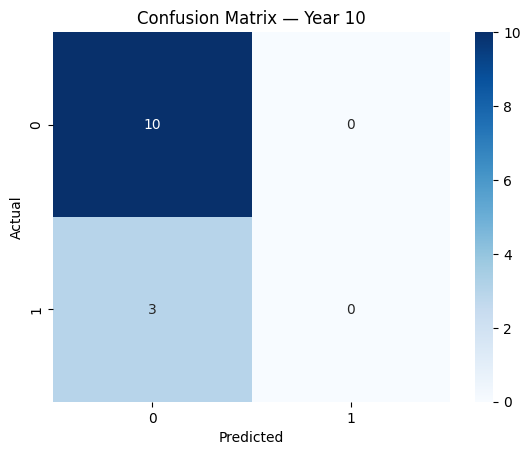

/tmp/ipykernel_26364/2794342565.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")


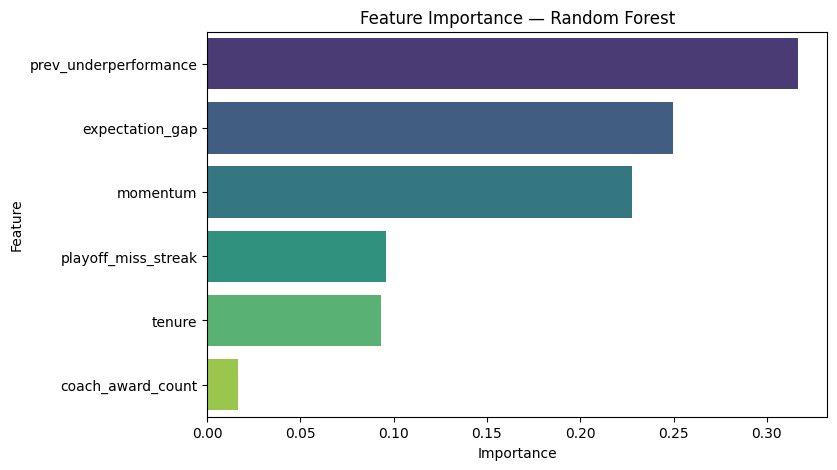


Feature Influence (higher = more impact on firing prediction):
                 Feature  Importance
3  prev_underperformance    0.316529
0        expectation_gap    0.249816
5               momentum    0.227797
2    playoff_miss_streak    0.095809
4                 tenure    0.093297
1      coach_award_count    0.016752


In [272]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION - RANDOM FOREST
# ===============================================================


# Define features and target

features = [
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]
target = "mid_season_change"

min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 10
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Model Random Forest")
print(f"Year Target: {target_year}")
print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")


X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# Predictions

test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.4
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])
roc_auc = roc_auc_score(y_test, test_data['pred_proba'])


print(f"\nEvaluation for year {target_year}:")
print(f"AUC:       {roc_auc:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"AUC:       {roc_auc_score(y_test, test_data['pred_proba']):.3f}")
print(f"Spearman:  {spearman_corr:.3f}")

predicted_teams = test_data[test_data["predicted_change"] == 1].sort_values("pred_proba", ascending=False)

print("\nTeams predicted to change coaches:")
# We show tmID because that is the "Entity" the question asks for
print(predicted_teams[["tmID", "coachID", "pred_proba", "prev_underperformance"]])

print("\nTop predicted coach changes (with actual result):")
print(
    test_data[[
        "pred_proba", "predicted_change", 
        "mid_season_change"#, "cumulative_win_ratio"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(test_data.shape[0])
)

# Evaluation


# Confusion Matrix

# Column [0]: probability of class 0: coach stays

# Column [1]: probability of class 1: coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance

importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance — Random Forest")
plt.show()

print("\nFeature Influence (higher = more impact on firing prediction):")
print(importance)


Model Logistic Regression
Year Target: 10
Treino: (129, 13) | Teste (10): (13, 13)
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Evaluation for year 10:
AUC:       0.933
Accuracy:  0.846
Precision: 0.667
Recall:    0.667
F1-score:  0.667
Spearman:  0.634

Teams predicted to change coaches:
    tmID     coachID  pred_proba  prev_underperformance
132  SAC  bouceje01w    0.519783              -0.049029
100  NYL  coylepa99w    0.474423              -0.002210
1    ATL  meadoma99w    0.467780               0.025792

Top predicted coach changes (with actual result):
     pred_proba  predicted_change  mid_season_change  expectation_gap
132    0.519783                 1                  1        -0.019066
100    0.474423                 1                  1         0.000000
1      0.467780                 1                  0        -0.368349
116    0.440084                 0                  0        -0.085499
38     0.393594                 0                  1         0.0000

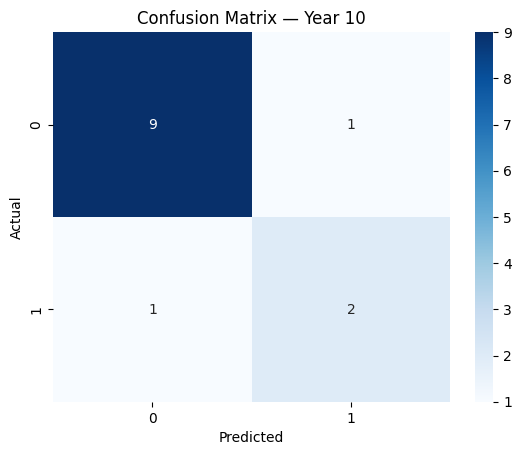


Feature Influence (higher = more impact on firing prediction):
                 Feature  Coefficient
4                 tenure     0.171053
2    playoff_miss_streak     0.012419
0        expectation_gap    -0.139682
5               momentum    -0.201658
1      coach_award_count    -0.214374
3  prev_underperformance    -0.516190


In [273]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION - LOGISTIC REGRESSION
# ===============================================================


# Define features and target

features = [
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]
target = "mid_season_change"

min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 10
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Model Logistic Regression")
print(f"Year Target: {target_year}")

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")


X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid = {
    'logreg__class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 4}], # 1:10 is "Super Paranoid"
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

model = GridSearchCV(
pipeline, 
    param_grid, 
    cv=5,             
    scoring='average_precision',  
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)

# Predictions

test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.45
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
roc_auc = roc_auc_score(y_test, test_data['pred_proba'])
spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])

print(f"\nEvaluation for year {target_year}:")
print(f"AUC:       {roc_auc:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Spearman:  {spearman_corr:.3f}")

predicted_teams = test_data[test_data["predicted_change"] == 1].sort_values("pred_proba", ascending=False)

print("\nTeams predicted to change coaches:")
# We show tmID because that is the "Entity" the question asks for
print(predicted_teams[["tmID", "coachID", "pred_proba", "prev_underperformance"]])

print("\nTop predicted coach changes (with actual result):")
print(
    test_data[[
        "pred_proba",
        "predicted_change", "mid_season_change", "expectation_gap"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(test_data.shape[0])
)

# Evaluation


# Confusion Matrix

# Column [0]: probability of class 0: coach stays

# Column [1]: probability of class 1: coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance

importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.best_estimator_.named_steps['logreg'].coef_[0]
}).sort_values("Coefficient", ascending=False)

print("\nFeature Influence (higher = more impact on firing prediction):")
print(importance)


In [274]:
# ===============================================================
# COACH CHANGE PREDICTION — ENSEMBLE MODEL (RF + LR)
# ===============================================================


# 1. SETUP & DATA SPLIT

features = [
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]

target = "mid_season_change"

# Filter for Starters (Min Stint)
min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 4
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Training Ensemble on {len(train_data)} rows.")
print(f"Predicting for {len(test_data)} teams in Year {target_year}.")

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 2. MODEL 1: RANDOM FOREST (The "Stability" Expert)

print("\nTraining Model 1: Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train, y_train)
probs_rf = rf_model.predict_proba(X_test)[:, 1]

# 3. MODEL 2: LOGISTIC REGRESSION (The "Ranking" Expert)

print("Training Model 2: Logistic Regression...")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid = {
    'logreg__class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 4}], # 1:10 is "Super Paranoid"
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

lr_model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,             
    scoring='f1',  
    n_jobs=-1,
    verbose=0
)
lr_model.fit(X_train, y_train)
probs_lr = lr_model.predict_proba(X_test)[:, 1]

print(f"Best LR Params: {lr_model.best_params_}")

# 4. THE ENSEMBLE (Averaging)
# ===============================================================
# We take the average of both models.
# This smooths out the "Paranoid" LR and boosts the "Shy" RF.
final_probs = (probs_rf + probs_lr) / 2

test_data = test_data.copy()
test_data["prob_rf"] = probs_rf
test_data["prob_lr"] = probs_lr
test_data["prob_ensemble"] = final_probs

# Threshold 0.35 is usually a good sweet spot for ensembles
threshold = 0.44
test_data["predicted_change"] = (test_data["prob_ensemble"] > threshold).astype(int)

# 5. EVALUATION
# ===============================================================
print("\n" + "="*40)
print("ENSEMBLE RESULTS")
print("="*40)

# Metrics
acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"], zero_division=0)
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, _ = spearmanr(y_test, test_data["prob_ensemble"])
roc_auc = roc_auc_score(y_test, test_data['prob_ensemble'])

print(f"AUC:       {roc_auc:.3f}")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Spearman:  {spearman_corr:.3f}")

# 6. THE FINAL LIST
print("\nProbability to change (Ensemble > {:.2f}):".format(threshold))
hit_list = test_data[test_data["predicted_change"] == 1].sort_values("prob_ensemble", ascending=False)

# Showing breakdown so you can see which model blamed them
cols = ["tmID", "coachID", "prob_ensemble", "prob_rf", "prob_lr", "mid_season_change"]
print(hit_list[cols])

# Answer Set
team_set = set(hit_list["tmID"].unique())
print(f"\nTeams predicted to change: {team_set}")

print("\nTop predicted coach changes (with actual result):")
print(
    test_data[[
        "prob_ensemble",
        "predicted_change", "mid_season_change"
    ]]
    .sort_values("prob_ensemble", ascending=False)
    .head(test_data.shape[0])
)

Training Ensemble on 48 rows.
Predicting for 14 teams in Year 4.

Training Model 1: Random Forest...
Training Model 2: Logistic Regression...
Best LR Params: {'logreg__C': 0.01, 'logreg__class_weight': {0: 1, 1: 4}, 'logreg__penalty': 'l2'}

ENSEMBLE RESULTS
AUC:       0.875
Accuracy:  0.786
Precision: 0.333
Recall:    0.500
F1-score:  0.400
Spearman:  0.456

Probability to change (Ensemble > 0.44):
    tmID     coachID  prob_ensemble   prob_rf   prob_lr  mid_season_change
125  SAC  mchugma99w       0.569311  0.546992  0.591631                  1
110  PHO  shumajo01w       0.552132  0.462583  0.641682                  0
19   CLE  hugheda99w       0.468584  0.346639  0.590530                  0

Teams predicted to change: {'SAC', 'CLE', 'PHO'}

Top predicted coach changes (with actual result):
     prob_ensemble  predicted_change  mid_season_change
125       0.569311                 1                  1
110       0.552132                 1                  0
19        0.468584          

Running Backtest Loop for Years: [3, 4, 5, 6, 7, 8, 9, 10]

Average Metrics (Years 3-10):
Year         6.500000
AUC          0.538119
Accuracy     0.805203
Precision    0.375000
Recall       0.333333
F1           0.320833
Spearman     0.058723
dtype: float64

Detailed Results:
   Year       AUC  Accuracy  Precision    Recall        F1  Spearman  \
0     3  0.000000  0.562500        0.0  0.000000  0.000000 -0.677365   
1     4  0.875000  0.857143        0.5  0.500000  0.500000  0.455733   
2     5  0.666667  0.769231        0.5  0.333333  0.400000  0.243975   
3     6  0.636364  0.846154        0.5  0.500000  0.500000  0.170941   
4     7  1.000000  0.928571        0.5  1.000000  0.666667  0.447214   
5     8  0.250000  0.846154        0.0  0.000000  0.000000 -0.231455   
6     9  0.076923  0.785714        0.0  0.000000  0.000000 -0.378412   
7    10  0.800000  0.846154        1.0  0.333333  0.500000  0.439155   

    Predicted_Teams_Set  
0  {NYL, WAS, MIA, UTA}  
1            {SAC, PH

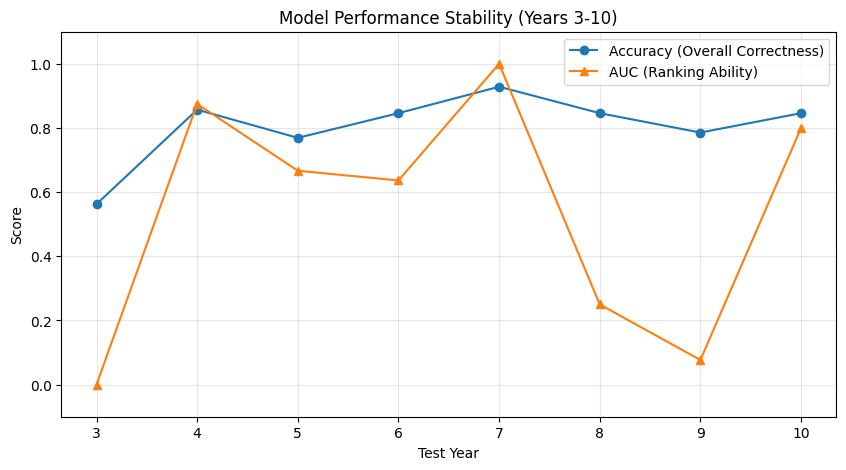

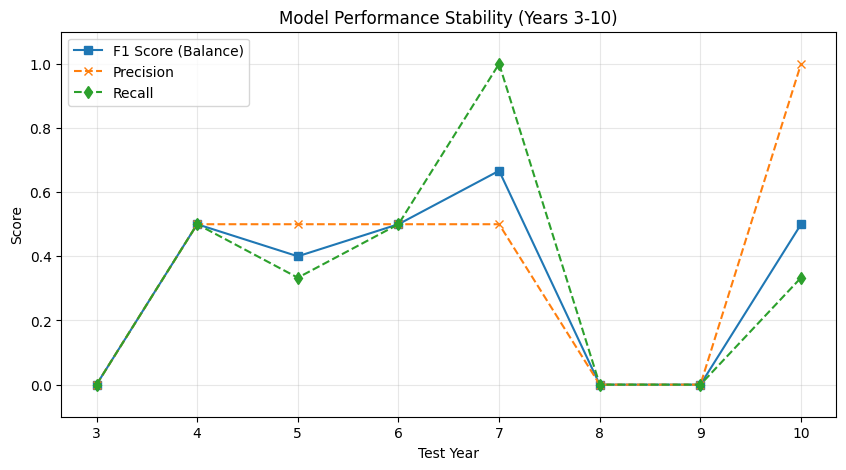

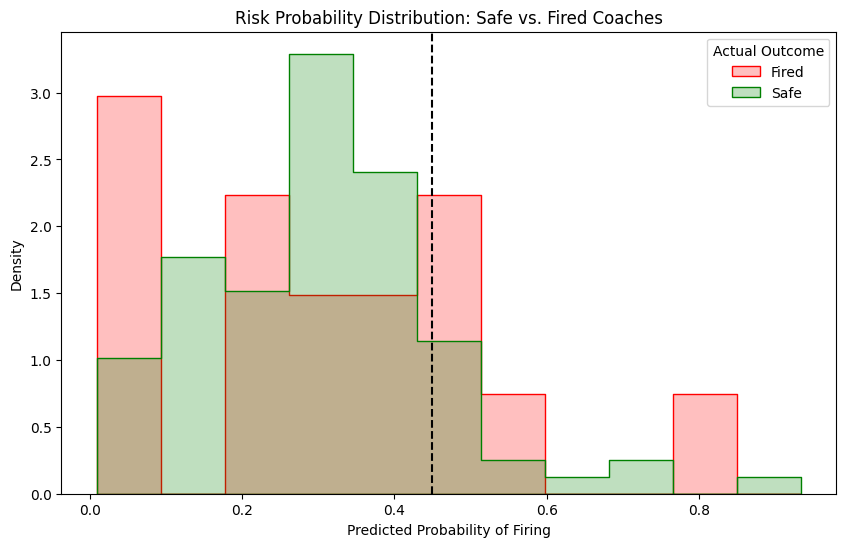

In [277]:
# Stats for all years

# 1. SETUP & DATA
# ===============================================================
features = [
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]

target = "mid_season_change"

# Filter for Starters (Min Stint)
min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

# 2. RUN LOOP FOR YEARS 3 TO 10
# ===============================================================
years_to_test = list(range(3, 11))
results_list = []
all_test_data = pd.DataFrame() # Store all predictions for plotting

print(f"Running Backtest Loop for Years: {years_to_test}")

for year in years_to_test:
    train = valid_data[valid_data["year"] < year]
    test = valid_data[valid_data["year"] == year]
    
    if len(test) == 0: continue

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model 1: Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        random_state=42
    )

    # Model 2: Logistic Regression
    lr_model = LogisticRegression(
        solver='liblinear',
        C=1.0,
        class_weight={0: 1, 1: 5},
        random_state=42
    )
    
    # Model 3: Gradient Boosting
    gb_model = GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

    # Voting Classifier Ensemble
    ensemble = VotingClassifier(
        estimators=[
            ('rf', rf_model),
            ('lr', lr_model),
            ('gb', gb_model)
        ],
        voting='soft',
        weights=[1, 1, 1]  
    )

    weights = compute_sample_weight(class_weight='balanced', y=y_train)

    ensemble.fit(X_train_scaled, y_train, sample_weight=weights)


    # Store predictions

    test_data = test.copy()
    final_probs = ensemble.predict_proba(X_test_scaled)[:, 1]
    test_data["prob_ensemble"] = final_probs
    threshold = 0.45

    test_data["pred_class"] = (final_probs > threshold).astype(int)
    all_test_data = pd.concat([all_test_data, test_data])

    current_year_teams = test_data.loc[test_data["pred_class"] == 1, "tmID"].unique()

    # Metrics
    metrics = {
        "Year": year,
        "AUC": roc_auc_score(y_test, final_probs) if len(y_test.unique()) > 1 else 0,
        "Accuracy": accuracy_score(y_test, test_data["pred_class"]),
        "Precision": precision_score(y_test, test_data["pred_class"], zero_division=0),
        "Recall": recall_score(y_test, test_data["pred_class"], zero_division=0),
        "F1": f1_score(y_test, test_data["pred_class"], zero_division=0),
        "Spearman": spearmanr(y_test, final_probs)[0],
        "Predicted_Teams_Set": set(current_year_teams)
    }
    results_list.append(metrics)

# 3. AVERAGE STATISTICS
# ===============================================================
results_df = pd.DataFrame(results_list)
avg_metrics = results_df.mean(numeric_only=True)

print("\nAverage Metrics (Years 3-10):")
print(avg_metrics)
print("\nDetailed Results:")
print(results_df)



# 5. ADDITIONAL PLOT A: METRIC STABILITY ACROSS YEARS
# ===============================================================
# Shows if the model is consistent or fluctuates
plt.figure(figsize=(10, 5))
plt.plot(results_df["Year"], results_df["Accuracy"], marker='o', label='Accuracy (Overall Correctness)')
plt.plot(results_df["Year"], results_df["AUC"], marker='^', label='AUC (Ranking Ability)')
plt.title("Model Performance Stability (Years 3-10)")
plt.xlabel("Test Year")
plt.ylabel("Score")
plt.ylim(-0.1, 1.1)
plt.xticks(years_to_test)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(results_df["Year"], results_df["F1"], marker='s', label='F1 Score (Balance)')
plt.plot(results_df["Year"], results_df["Precision"], marker='x', linestyle='--', label='Precision')
plt.plot(results_df["Year"], results_df["Recall"], marker='d', linestyle='--', label='Recall')
plt.title("Model Performance Stability (Years 3-10)")
plt.xlabel("Test Year")
plt.ylabel("Score")
plt.ylim(-0.1, 1.1)
plt.xticks(years_to_test)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. ADDITIONAL PLOT B: RISK DISTRIBUTION 
# ===============================================================
# Does the model successfully separate Fired (1) from Safe (0)?
plt.figure(figsize=(10, 6))
sns.histplot(data=all_test_data, x="prob_ensemble", hue="mid_season_change", element="step", stat="density", common_norm=False, palette={0: "green", 1: "red"})
plt.axvline(0.45, color='black', linestyle='--', label='Decision Threshold (0.45)')
plt.title("Risk Probability Distribution: Safe vs. Fired Coaches")
plt.xlabel("Predicted Probability of Firing")
plt.legend(title="Actual Outcome", labels=["Fired", "Safe"])
plt.show()

Training Ensemble on 142 rows.
Predicting for 12 teams in Year 11.

Training Model 1: Random Forest...
Training Model 2: Logistic Regression...

PREDICTIONS FOR YEAR 11
Teams predicted to change coaches:
    tmID     coachID  prob_ensemble
143  SAS  hugheda99w       0.607836


/tmp/ipykernel_26364/3488833263.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test_data.sort_values("prob_ensemble", ascending=False), x="tmID", y="prob_ensemble", palette="coolwarm")


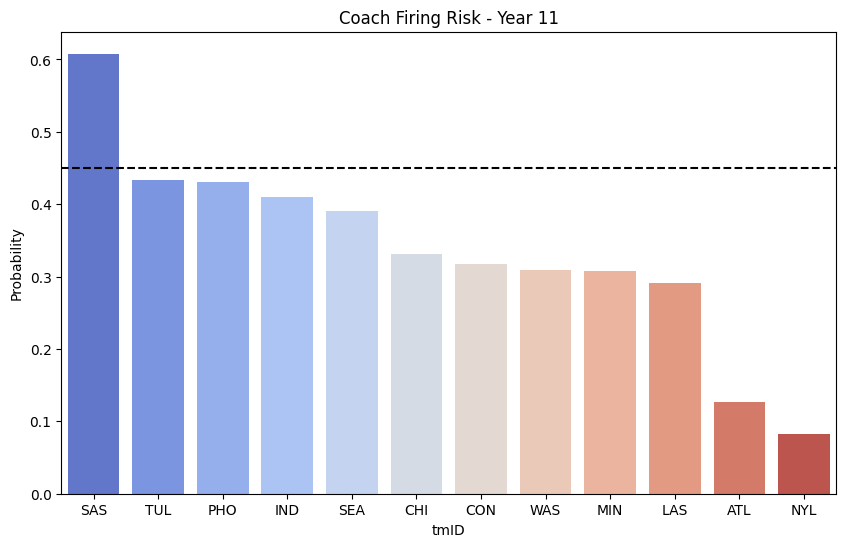

In [276]:
# ===============================================================
# COACH CHANGE PREDICTION — VOTING CLASSIFIER 
# ===============================================================

# Year 11

features = [
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]

target = "mid_season_change"

# Filter for Starters (Min Stint)
min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 11
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Training Ensemble on {len(train_data)} rows.")
print(f"Predicting for {len(test_data)} teams in Year {target_year}.")

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. MODEL 1: RANDOM FOREST (The "Stability" Expert)

print("\nTraining Model 1: Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=42
    )

# 3. MODEL 2: LOGISTIC REGRESSION (The "Ranking" Expert)

print("Training Model 2: Logistic Regression...")

lr_model = LogisticRegression(
    solver='liblinear', 
    C=1.0, 
    class_weight={0: 1, 1: 5}, 
    random_state=42
)

# 4. Model 3: Gradient Boosting Classifier (The "Balanced" Expert)

clf_model = GradientBoostingClassifier(
    n_estimators=150, 
    learning_rate=0.05, 
    max_depth=3, 
)  

# 5. VOTING CLASSIFIER ENSEMBLE
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('gbc', clf_model)
    ],
    voting='soft', 
    weights=[1, 1, 1]  
)


weights = compute_sample_weight(class_weight='balanced', y=y_train)

voting_clf.fit(X_train_scaled, y_train, sample_weight=weights)

test_data = test_data.copy()
test_data["prob_ensemble"] = voting_clf.predict_proba(X_test_scaled)[:, 1]


threshold = 0.45
test_data["predicted_change"] = (test_data["prob_ensemble"] > threshold).astype(int)

# 5. Final Output

print("\n" + "="*50)
print(f"PREDICTIONS FOR YEAR {target_year}")
print("="*50)

print("Teams predicted to change coaches:")
predicted_teams = test_data[test_data["predicted_change"] == 1].sort_values("prob_ensemble", ascending=False)
print(predicted_teams[["tmID", "coachID", "prob_ensemble"]])

plt.figure(figsize=(10, 6))
sns.barplot(data=test_data.sort_values("prob_ensemble", ascending=False), x="tmID", y="prob_ensemble", palette="coolwarm")
plt.axhline(threshold, color='black', linestyle='--', label=f'Threshold {threshold}')
plt.title(f"Coach Firing Risk - Year {target_year}")
plt.ylabel("Probability")
plt.show()